In [11]:

# If inside a Jupyter notebook
!pip install scikit-learn

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 8.1 MB/s eta 0:00:0000:0100:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


In [25]:
# === Setup Cell for EFM Checkpoint Explorer (Jupyter Notebook) ===

import os, warnings

# ✅ Limit threading noise and control CPU use
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["MKL_NUM_THREADS"] = "8"

# ✅ Clean warnings (UMAP, OpenMP, tqdm)
warnings.filterwarnings("ignore", category=UserWarning, module="umap")
warnings.filterwarnings("ignore", message=".*omp_set_nested.*")
warnings.filterwarnings("ignore", message=".*IProgress not found.*")

# ✅ Enable tqdm notebook progress bars (only for Jupyter classic)
try:
    from tqdm.notebook import tqdm
except Exception:
    from tqdm import tqdm

# ✅ If widgets are missing (fixes tqdm + interactive plots)
!pip install -q ipywidgets umap-learn
!jupyter nbextension enable --py widgetsnbextension > /dev/null 2>&1

In [7]:
import torch, json, os

# --- Paths ---
ckpt_path = os.path.expanduser("../runs/efm_base.ckpt")
cfg_path  = os.path.expanduser("../runs/ssl_config.json")

# --- Load the checkpoint ---
ckpt = torch.load(ckpt_path, map_location="cpu")
print("Top-level keys:", ckpt.keys())


# --- Usually contains only 'model' ---
state_dict = ckpt["model"]
print(f"Total tensors: {len(state_dict)}")

# --- List the first few parameter names ---
for k in list(state_dict.keys())[:20]:
    print(f"{k:<40}", state_dict[k].shape)

# --- Optional: inspect configuration ---
with open(cfg_path) as f:
    cfg = json.load(f)
print("\nConfig summary:")
print(json.dumps(cfg, indent=2))

Top-level keys: dict_keys(['model'])
Total tensors: 27
raw_enc.net.0.weight                     torch.Size([64, 19, 7])
raw_enc.net.0.bias                       torch.Size([64])
raw_enc.net.2.weight                     torch.Size([128, 64, 7])
raw_enc.net.2.bias                       torch.Size([128])
raw_enc.net.6.weight                     torch.Size([512, 128])
raw_enc.net.6.bias                       torch.Size([512])
spec_enc.net.0.weight                    torch.Size([64, 19, 3, 3])
spec_enc.net.0.bias                      torch.Size([64])
spec_enc.net.2.weight                    torch.Size([128, 64, 3, 3])
spec_enc.net.2.bias                      torch.Size([128])
spec_enc.net.6.weight                    torch.Size([512, 128])
spec_enc.net.6.bias                      torch.Size([512])
fusion.fc.weight                         torch.Size([512, 1024])
fusion.fc.bias                           torch.Size([512])
raw_proj.net.0.weight                    torch.Size([512, 512])
raw_proj.

/var/folders/_3/0jcbj49s3y1_zyg5ls7_6rzc0000gn/T/ipykernel_57267/1001920567.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cp

In [13]:
# EFM Checkpoint Explorer (Local Notebook)

import os, glob, math, random, json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.style.use("seaborn-v0_8")

# --- Paths ---
CKPT_PATH = "../runs/efm_base.ckpt"   # adjust if needed
NPZ_ROOT  = "../eeg_npz_sample"                                # your sample folder
MAX_PER_DATASET = 50  # limit for speed
device = "cpu"

print("Device:", device)

Device: cpu


In [14]:
def safe_normalize(x: torch.Tensor, dim=-1, eps=1e-6):
    return x / (x.norm(dim=dim, keepdim=True).clamp_min(eps))

@torch.no_grad()
def simple_log_stft(x: torch.Tensor, n_fft=256, hop=128, eps=1e-6):
    """Compute log power STFT per channel."""
    B, C, T = x.shape
    out = []
    for c in range(C):
        S = torch.stft(x[:, c, :], n_fft=n_fft, hop_length=hop, return_complex=True)
        P = (S.real**2 + S.imag**2).clamp_min(eps)
        out.append(torch.log(P + eps))
    return torch.stack(out, dim=1)

In [15]:
class DummyEFMRawEncoder(nn.Module):
    def __init__(self, out_dim=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(19,64,7,padding=3), nn.GELU(),
            nn.Conv1d(64,128,7,padding=3), nn.GELU(),
            nn.AdaptiveAvgPool1d(1), nn.Flatten(), nn.Linear(128,out_dim)
        )
    def forward(self, x): return self.net(x)

class DummyEFMSpecEncoder(nn.Module):
    def __init__(self, in_ch=19, out_dim=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch,64,3,padding=1), nn.GELU(),
            nn.Conv2d(64,128,3,padding=1), nn.GELU(),
            nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(128,out_dim)
        )
    def forward(self, x): return self.net(x)

class DummyFusion(nn.Module):
    def __init__(self, dim=512):
        super().__init__()
        self.fc = nn.Linear(dim*2, dim)
    def forward(self, r,s): return self.fc(torch.cat([r,s],dim=-1))

class ProjHead(nn.Module):
    def __init__(self, in_dim, proj_dim=256):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(in_dim,in_dim), nn.GELU(), nn.Linear(in_dim,proj_dim))
    def forward(self, x): return safe_normalize(self.net(x),dim=-1)

class EFM_SSL_Dummy(nn.Module):
    def __init__(self, proj_dim=256):
        super().__init__()
        self.raw_enc  = DummyEFMRawEncoder(512)
        self.spec_enc = DummyEFMSpecEncoder(19,512)
        self.fusion   = DummyFusion(512)
        self.raw_proj = ProjHead(512,proj_dim)
        self.spec_proj= ProjHead(512,proj_dim)
    def forward_all(self, x_raw, x_spec):
        r = self.raw_enc(x_raw)
        s = self.spec_enc(x_spec)
        f = self.fusion(r,s)
        return r,s,f,self.raw_proj(r),self.spec_proj(s)

In [16]:
ckpt = torch.load(CKPT_PATH, map_location="cpu")
state = ckpt.get("model", ckpt)

model = EFM_SSL_Dummy()
missing, unexpected = model.load_state_dict(state, strict=False)
print("Loaded checkpoint:", CKPT_PATH)
print("Missing keys:", missing)
print("Unexpected:", unexpected)
print("Total params:", sum(p.numel() for p in model.parameters()))

# Quick dummy forward
x = torch.zeros(2,19,1024)
s = simple_log_stft(x)
with torch.no_grad():
    r,spec,f,qr,qs = model.forward_all(x,s)
print("raw_lat",r.shape,"spec_lat",spec.shape,"fusion",f.shape)

Loaded checkpoint: ../runs/efm_base.ckpt
Missing keys: []
Unexpected: ['jigsaw_head.fc.weight', 'jigsaw_head.fc.bias', 'domain_head.fc.weight', 'domain_head.fc.bias', 'proto.keys']
Total params: 1595776
raw_lat torch.Size([2, 512]) spec_lat torch.Size([2, 512]) fusion torch.Size([2, 512])


/var/folders/_3/0jcbj49s3y1_zyg5ls7_6rzc0000gn/T/ipykernel_57267/3595083016.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CKPT_PATH, map_location="cp

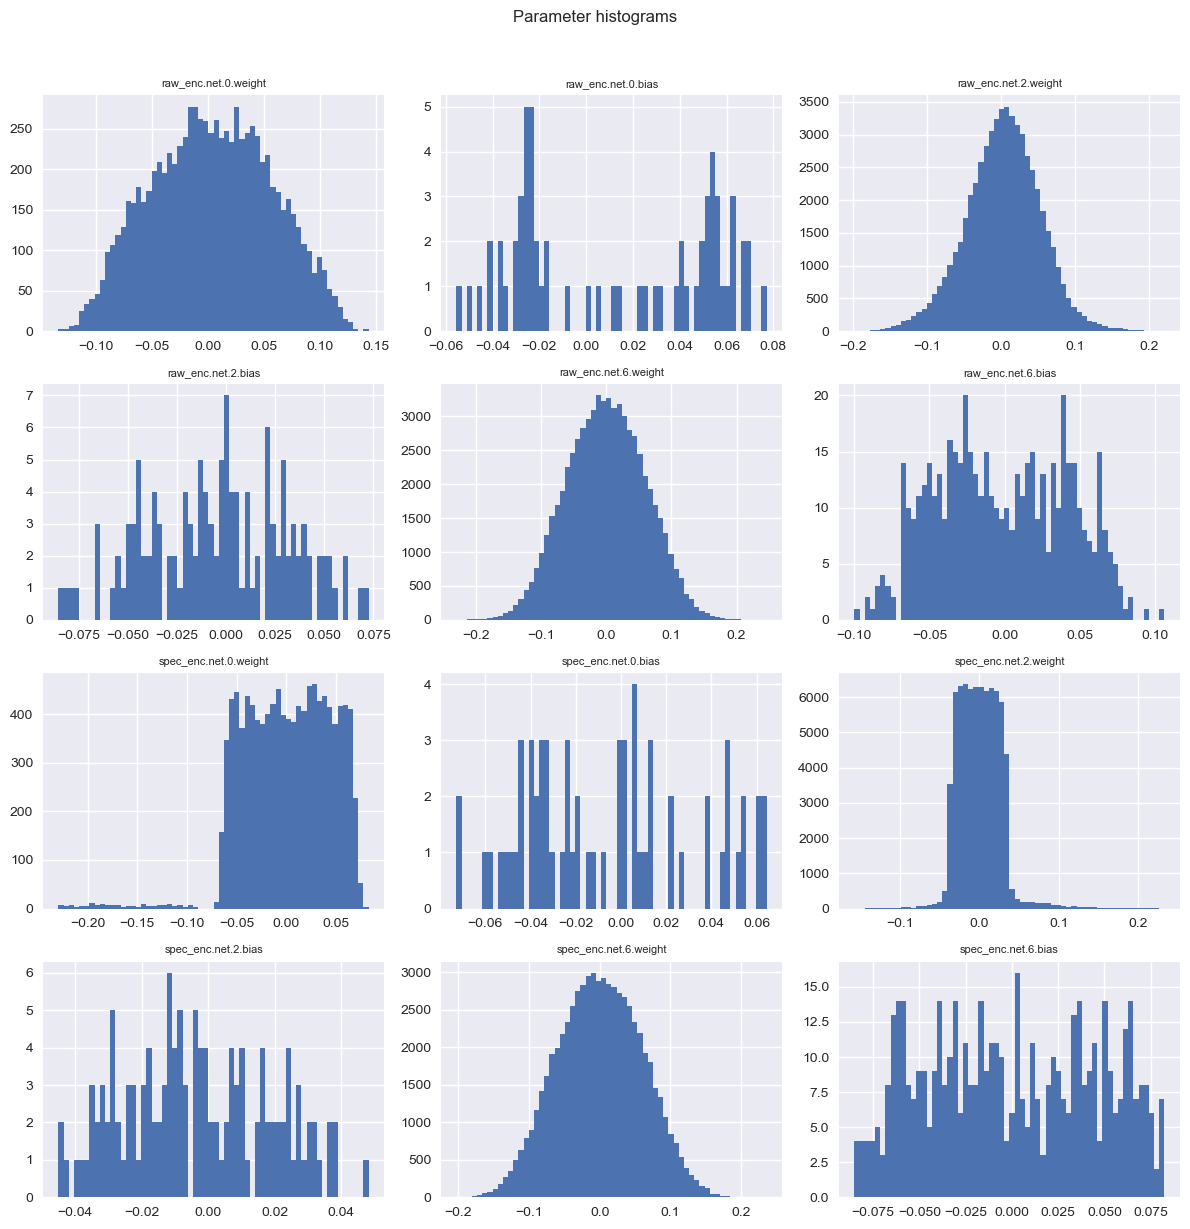

In [17]:
def plot_param_hists(m: nn.Module, max_plots=12):
    named = [(n,p) for n,p in m.named_parameters() if p.requires_grad]
    cols, rows = 3, math.ceil(min(len(named),max_plots)/3)
    plt.figure(figsize=(4*cols,3*rows))
    for i,(n,p) in enumerate(named[:max_plots],1):
        plt.subplot(rows,cols,i)
        plt.hist(p.detach().cpu().flatten().numpy(),bins=60)
        plt.title(n,fontsize=8)
    plt.suptitle("Parameter histograms",y=1.02)
    plt.tight_layout()
    plt.show()

plot_param_hists(model)

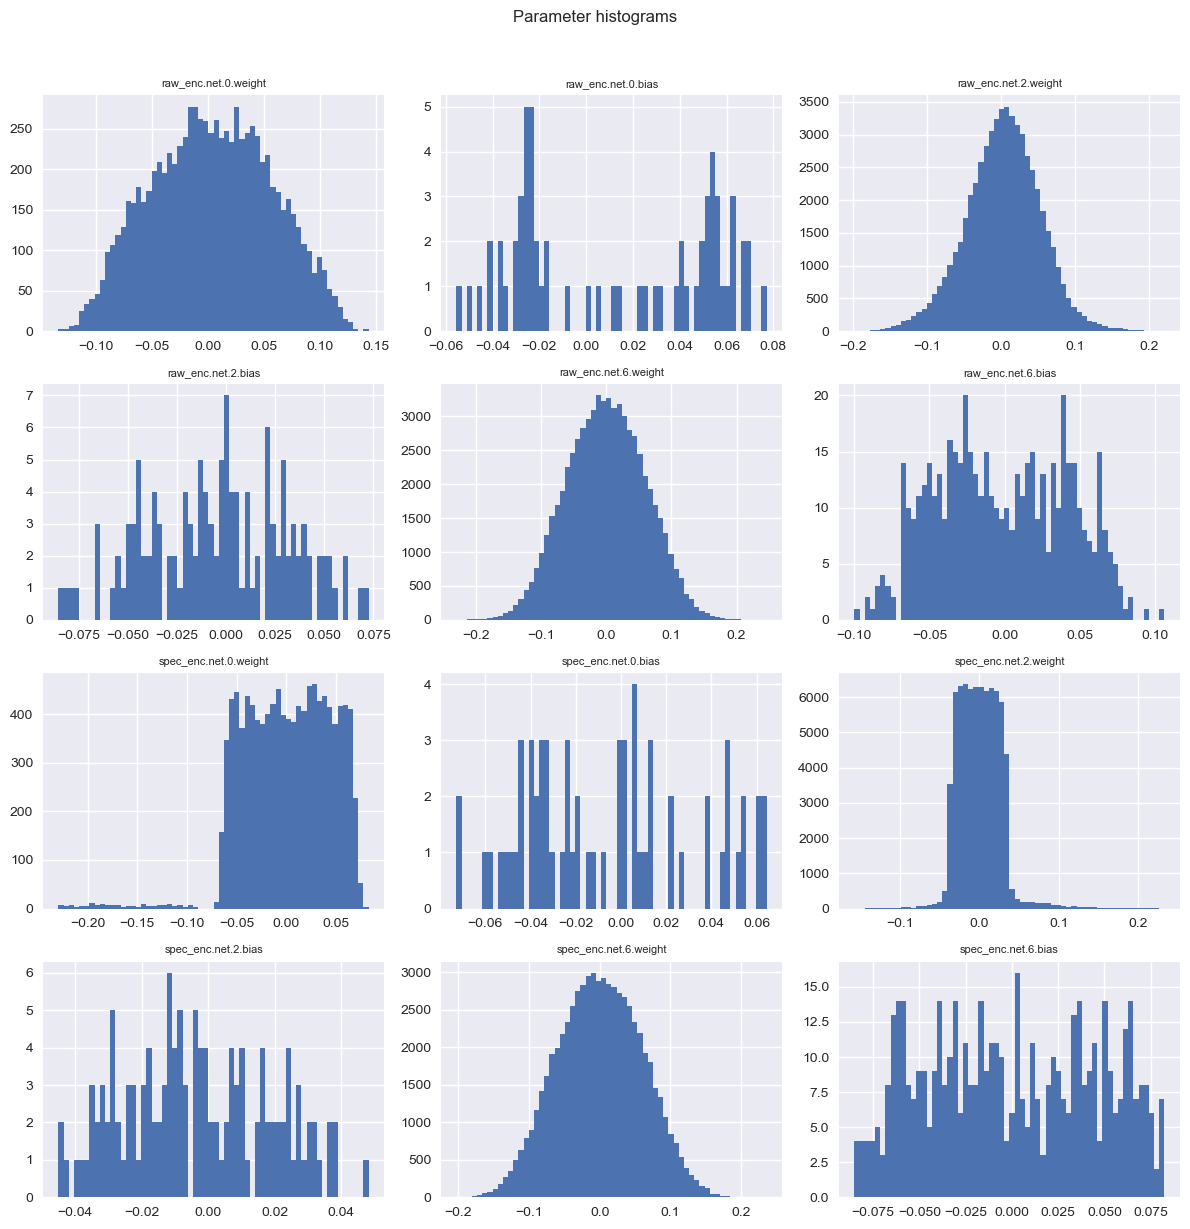

In [18]:
def plot_param_hists(m: nn.Module, max_plots=12):
    named = [(n,p) for n,p in m.named_parameters() if p.requires_grad]
    cols, rows = 3, math.ceil(min(len(named),max_plots)/3)
    plt.figure(figsize=(4*cols,3*rows))
    for i,(n,p) in enumerate(named[:max_plots],1):
        plt.subplot(rows,cols,i)
        plt.hist(p.detach().cpu().flatten().numpy(),bins=60)
        plt.title(n,fontsize=8)
    plt.suptitle("Parameter histograms",y=1.02)
    plt.tight_layout()
    plt.show()

plot_param_hists(model)

In [31]:
import os, glob, json, math, pathlib, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

plt.rcParams["figure.figsize"] = (6,5)
torch.set_grad_enabled(False)

def safe_normalize(x, dim=-1, eps=1e-6):
    denom = x.norm(dim=dim, keepdim=True).clamp_min(eps)
    return x / denom

class DummyEFMRawEncoder(nn.Module):
    def __init__(self, out_dim=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(19, 64, 7, padding=3), nn.GELU(),
            nn.Conv1d(64,128, 7, padding=3), nn.GELU(),
            nn.AdaptiveAvgPool1d(1), nn.Flatten(), nn.Linear(128, out_dim)
        )
    def forward(self, x):  # (B,C,T)
        return self.net(x)

class DummyEFMSpecEncoder(nn.Module):
    def __init__(self, in_ch=19, out_dim=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 64, 3, padding=1), nn.GELU(),
            nn.Conv2d(64, 128,3, padding=1), nn.GELU(),
            nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(128, out_dim)
        )
    def forward(self, x):  # (B,C,F,T)
        return self.net(x)

class SimpleLogSTFT(nn.Module):
    def __init__(self, n_fft=256, hop=128, eps=1e-6):
        super().__init__()
        self.n_fft, self.hop, self.eps = n_fft, hop, eps
    def forward(self, x):  # x: (B,C,T)
        B,C,T = x.shape
        out = []
        for c in range(C):
            S = torch.stft(x[:,c,:], n_fft=self.n_fft, hop_length=self.hop, return_complex=True)
            P = (S.real**2 + S.imag**2).clamp_min(self.eps)
            out.append(torch.log(P + self.eps))
        return torch.stack(out, dim=1)  # (B,C,F,TT)

def dataset_color_map(labels):
    uniq = sorted(set(labels))
    cmap = {lab: plt.cm.tab10(i % 10) for i, lab in enumerate(uniq)}
    return cmap, uniq

def scatter_2d(X2, labels, title):
    cmap, uniq = dataset_color_map(labels)
    labels = np.array(labels)
    plt.figure(figsize=(6,5))
    for lab in uniq:
        idx = labels == lab
        plt.scatter(X2[idx,0], X2[idx,1], s=28, alpha=0.8, c=[cmap[lab]], label=lab)
    plt.title(title)
    plt.grid(True, alpha=0.25)
    plt.legend(frameon=True, fontsize=9)
    plt.tight_layout()
    plt.show()

In [33]:
# paths (edit if needed)
ckpt_path = "../runs/efm_base.ckpt"   # or your local copy
data_root = "../eeg_npz_sample"                               # folder with chbmit/, tuh.../, tusz.../

# load weights
ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=False)
sd = ckpt["model"]

# build encoders and load
raw_enc  = DummyEFMRawEncoder(512)
spec_enc = DummyEFMSpecEncoder(19, 512)

missing = raw_enc.load_state_dict({k.replace("module.",""): v for k,v in sd.items() if k.startswith("raw_enc.")}, strict=False)
missing2= spec_enc.load_state_dict({k.replace("module.",""): v for k,v in sd.items() if k.startswith("spec_enc.")}, strict=False)

raw_enc.eval(); spec_enc.eval()
stft = SimpleLogSTFT()

print("Loaded raw/spec encoders. Missing keys (ok for heads/fusion):")
print(" raw:", missing)
print(" spec:", missing2)

# collect a small sample across datasets (change N if you want)
N_PER_DIR = 10  # try 20–100 if you want denser plots
paths = []
labels = []
for d in sorted(os.listdir(data_root)):
    dpath = os.path.join(data_root, d)
    if not os.path.isdir(dpath): 
        continue
    files = sorted(glob.glob(os.path.join(dpath, "*.npz")))
    pick = files[:N_PER_DIR]
    paths.extend(pick)
    labels.extend([d]*len(pick))

print(f"Found {len(paths)} samples total from {len(set(labels))} datasets.")

# compute embeddings
X_fusion = []
y_datasets = []

for pth, lab in zip(paths, labels):
    arr = np.load(pth, allow_pickle=True)
    x = torch.from_numpy(arr["x"].astype(np.float32))  # (C,T)
    if x.ndim == 2:
        x = x.unsqueeze(0)  # (1,C,T)

    # raw latent
    r_lat = raw_enc(x)                  # (1,512)

    # spec latent
    spec = stft(x)                      # (1,C,F,T)
    s_lat = spec_enc(spec)              # (1,512)

    # fusion (just concat like in training before fusion FC): (1,1024) -> for viz it's fine
    fusion = torch.cat([r_lat, s_lat], dim=-1).squeeze(0).numpy()
    X_fusion.append(fusion)
    y_datasets.append(lab)

X_fusion = np.stack(X_fusion, axis=0)        # (N, 1024)
y_datasets = np.array(y_datasets)
print("Embeddings shape:", X_fusion.shape)

Loaded raw/spec encoders. Missing keys (ok for heads/fusion):
 raw: _IncompatibleKeys(missing_keys=['net.0.weight', 'net.0.bias', 'net.2.weight', 'net.2.bias', 'net.6.weight', 'net.6.bias'], unexpected_keys=['raw_enc.net.0.weight', 'raw_enc.net.0.bias', 'raw_enc.net.2.weight', 'raw_enc.net.2.bias', 'raw_enc.net.6.weight', 'raw_enc.net.6.bias'])
 spec: _IncompatibleKeys(missing_keys=['net.0.weight', 'net.0.bias', 'net.2.weight', 'net.2.bias', 'net.6.weight', 'net.6.bias'], unexpected_keys=['spec_enc.net.0.weight', 'spec_enc.net.0.bias', 'spec_enc.net.2.weight', 'spec_enc.net.2.bias', 'spec_enc.net.6.weight', 'spec_enc.net.6.bias'])
Found 15 samples total from 3 datasets.
Embeddings shape: (15, 1024)


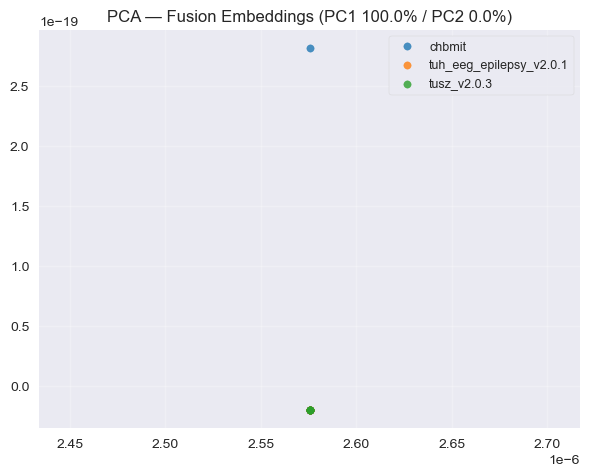

Using t-SNE perplexity: 5 (n=15)


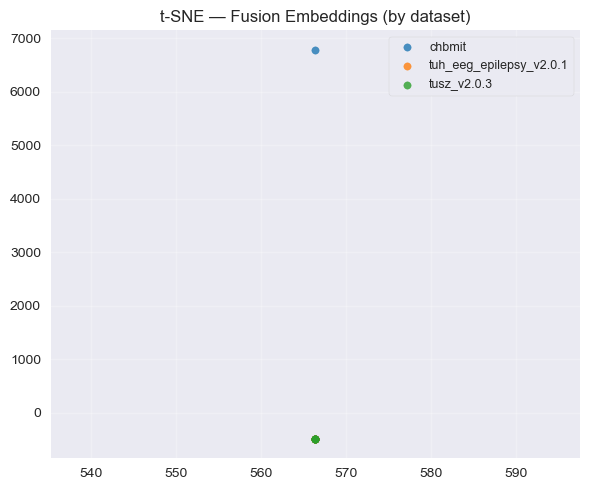

In [34]:
# PCA (nice quick view)
pca = PCA(n_components=2, random_state=0)
Xp = pca.fit_transform(X_fusion)
scatter_2d(Xp, y_datasets, 
           f"PCA — Fusion Embeddings (PC1 {100*pca.explained_variance_ratio_[0]:.1f}% / PC2 {100*pca.explained_variance_ratio_[1]:.1f}%)")

# t-SNE with safe perplexity (< n_samples)
n = len(X_fusion)
perp = max(5, min(30, (n - 1) // 3))   # safe heuristic
print(f"Using t-SNE perplexity: {perp} (n={n})")

tsne = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=perp, random_state=0)
Xt = tsne.fit_transform(X_fusion)
scatter_2d(Xt, y_datasets, "t-SNE — Fusion Embeddings (by dataset)")

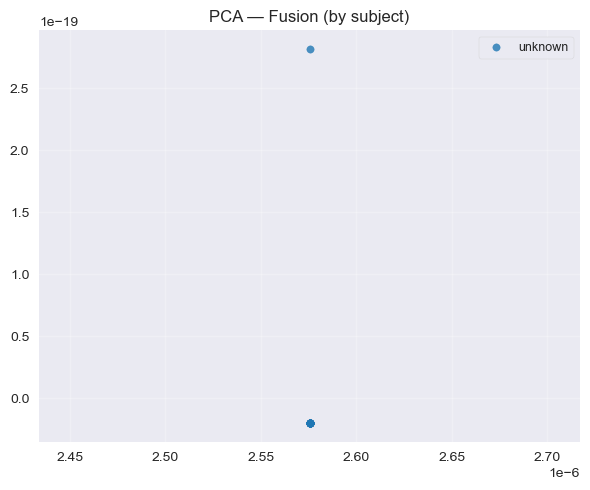

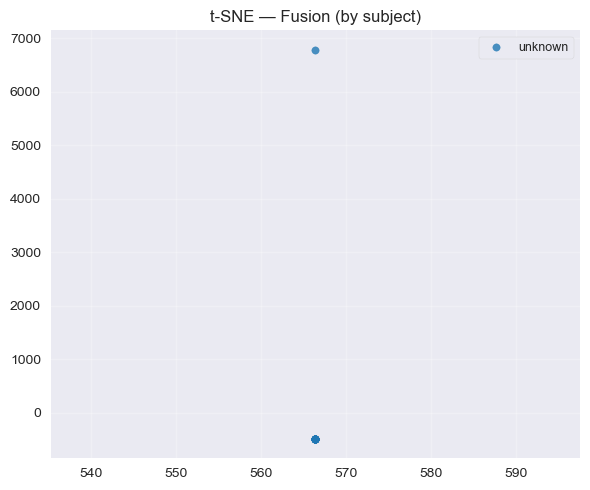

In [35]:
subjects = []
for pth in paths:
    d = np.load(pth, allow_pickle=True)
    subjects.append(str(d.get("subject", "unknown")))

subjects = np.array(subjects)
scatter_2d(Xp, subjects, "PCA — Fusion (by subject)")
scatter_2d(Xt, subjects, "t-SNE — Fusion (by subject)")